### Student Information
Name: 徐偉晉

Student ID: 109022127

GitHub ID: Wayne48763

Kaggle name: WayneHsu123

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the DM2023-Lab2-master. You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 27th 11:59 pm, Wednesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 31th 11:59 pm, Sunday)__. 

In [1]:
### Begin Assignment Here
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(torch.cuda.is_available())

True


# Load Data

In [3]:
# load data from pickle file
df_train = pd.read_pickle('./data/train_unbias.pkl')
df_test = pd.read_pickle('./data/test.pkl')

In [4]:
df_train.head()

,tweet_id,hashtags,text,identification,emotion,text_clean
0,0x241418,"[facebookdown, instagramisdown, bored]",Facebook's isn't working! Anyone else having t...,train,anger,Facebook's working! Anyone else trouble? #face...
1,0x36ccb2,[],@ASK_des His death really <LH> me off!,train,anger,@ASK_des His death really <LH> off!
2,0x22f974,[shooting],@CNN <LH> Guy's #shooting rampant occurred in ...,train,anger,@CNN <LH> Guy's #shooting rampant occurred Las...
3,0x2edf43,[],It's my pay day and I'm not getting paid <LH>,train,anger,It's pay day I'm getting paid <LH>
4,0x2c3b05,"[PhoenixRally, message, Madness]",#PhoenixRally some dude (#Talkinghead)said the...,train,anger,#PhoenixRally dude (#Talkinghead)said there's ...


In [5]:
# print max length of sentences
print('max length of sentences: ', df_train['text'].str.len().max())

max length of sentences:  158


# Data Preprocessing

In [6]:
from transformers import RobertaTokenizerFast
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

/cluster/home/WayneHsu/DM2023-Lab2-Master/datamining/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
tokenizer = RobertaTokenizerFast.from_pretrained('cardiffnlp/twitter-roberta-base-emotion-latest')

In [8]:
# build label encoder
ohe = OneHotEncoder(sparse_output=True)
ohe.fit(df_train[['emotion']])
print(ohe.categories_)

[array(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness',
       'surprise', 'trust'], dtype=object)]


In [9]:
df_train['label'] = ohe.transform(df_train[['emotion']]).toarray().tolist()
df_test['label'] = 0

In [10]:
df_train.head()

,tweet_id,hashtags,text,identification,emotion,text_clean,label
0,0x241418,"[facebookdown, instagramisdown, bored]",Facebook's isn't working! Anyone else having t...,train,anger,Facebook's working! Anyone else trouble? #face...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,0x36ccb2,[],@ASK_des His death really <LH> me off!,train,anger,@ASK_des His death really <LH> off!,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,0x22f974,[shooting],@CNN <LH> Guy's #shooting rampant occurred in ...,train,anger,@CNN <LH> Guy's #shooting rampant occurred Las...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,0x2edf43,[],It's my pay day and I'm not getting paid <LH>,train,anger,It's pay day I'm getting paid <LH>,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,0x2c3b05,"[PhoenixRally, message, Madness]",#PhoenixRally some dude (#Talkinghead)said the...,train,anger,#PhoenixRally dude (#Talkinghead)said there's ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [11]:
# build dataset
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score
import gc

class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=160):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]['text']
        label = self.df.iloc[idx]['label']
        encoding = self.tokenizer(text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')
        id = self.df.iloc[idx]['tweet_id']
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float),
            'id': id
        }
    


In [12]:
# train test split
dataset = TweetDataset(df_train, tokenizer, max_len=160)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.1, random_state=42)
dataset = None
# train_dataset = torch.load('./data/train_dataset.pt')
# val_dataset = torch.load('./data/val_dataset.pt')

In [13]:
# torch.save(train_dataset, './data/train_dataset.pt')
# torch.save(val_dataset, './data/val_dataset.pt')

In [14]:
print('train dataset size: ', len(train_dataset))
print('val dataset size: ', len(val_dataset))

train dataset size:  287042
val dataset size:  31894


In [15]:
# build dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:
from transformers import RobertaForSequenceClassification

In [21]:
model = RobertaForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-emotion-latest', num_labels=8)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion-latest and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [23]:
EPOCHS = 3

In [24]:
# train model
model.cuda()
model.train()
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_f1s = []
val_f1s = []

for epoch in range(EPOCHS):
    train_loss = 0
    train_acc = 0
    train_f1 = 0
    val_loss = 0
    val_acc = 0
    val_f1 = 0
    
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].cuda().squeeze()
        attention_mask = batch['attention_mask'].cuda()
        labels = batch['label'].cuda()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (outputs[1].argmax(1) == labels.argmax(1)).sum().item()
        train_f1 += f1_score(labels.cpu().numpy().argmax(1), outputs[1].argmax(1).cpu().numpy(), average='macro')
        
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].cuda().squeeze()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['label'].cuda()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]

            val_loss += loss.item()
            val_acc += (outputs[1].argmax(1) == labels.argmax(1)).sum().item()
            val_f1 += f1_score(labels.cpu().numpy().argmax(1), outputs[1].argmax(1).cpu().numpy(), average='macro')
    
    train_loss /= len(train_loader)
    train_acc /= len(train_dataset)
    train_f1 /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_dataset)
    val_f1 /= len(val_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print('Epoch: ', epoch+1)
    print('Train loss: ', train_loss)
    print('Train acc: ', train_acc)
    print('Train f1: ', train_f1)
    print('Val loss: ', val_loss)
    print('Val acc: ', val_acc)
    print('Val f1: ', val_f1)
    torch.save(model, f'./model_base_unbias/roberta_{epoch+1}.pt')

  0%|          | 0/8971 [00:00<?, ?it/s]

100%|██████████| 997/997 [01:04<00:00, 15.45it/s]


Epoch:  1
Train loss:  0.24645784437962034
Train acc:  0.5365765288703396
Train f1:  0.49821209565713853
Val loss:  0.22639521812214894
Val acc:  0.5788549570452123
Val f1:  0.5457560215507418


100%|██████████| 997/997 [01:04<00:00, 15.44it/s]


Epoch:  2
Train loss:  0.20923451261318537
Train acc:  0.6142620243727399
Train f1:  0.5759249460959289
Val loss:  0.21681996839216264
Val acc:  0.6021195209130243
Val f1:  0.5630442411690282


100%|██████████| 997/997 [01:04<00:00, 15.45it/s]


Epoch:  3
Train loss:  0.18750497004719643
Train acc:  0.6595236933967852
Train f1:  0.6231520935004105
Val loss:  0.22015168059733112
Val acc:  0.6057252147739387
Val f1:  0.5663821008320888


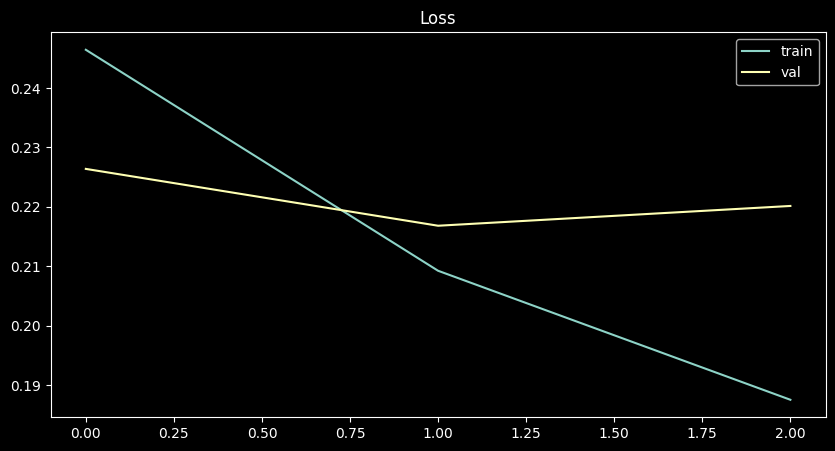

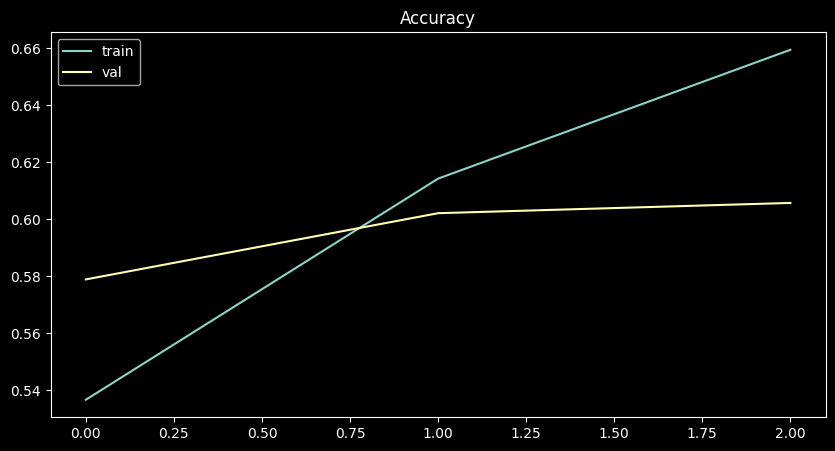

In [25]:
# plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.title('Loss')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Accuracy')
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='val')
plt.legend()
plt.show()

In [26]:
torch.save(model, './model_base_unbias/roberta_base_emo.pt')

In [27]:
model = torch.load('./model_base_unbias/roberta_base_emo.pt')
model.cuda()
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [28]:
test_dataset = TweetDataset(df_test, tokenizer, max_len=160)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
preds = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].cuda().squeeze()
        attention_mask = batch['attention_mask'].cuda()

        outputs = model(input_ids, attention_mask=attention_mask)
        
        labels = ohe.inverse_transform(outputs[0].cpu().numpy())
        
        for id, label in zip(batch['id'], labels):
            preds.append([id, label[0]])
    

100%|██████████| 12875/12875 [16:24<00:00, 13.07it/s]


In [30]:
df = pd.DataFrame(preds, columns=['id', 'emotion'])
print(df.shape)
df.to_csv('roberta_base_unbias_result.csv', index=False)

(411972, 2)
